<img align="left" src="https://cdn-images-1.medium.com/max/1200/1*iDQvKoz7gGHc6YXqvqWWZQ.png" width="85" height="80" >
<br>

#  Custom Real-Time Object Detection

<br>



This notebook is part of the tutorial [Custom real-time object detection in the browser using TensorFlow.js](https://medium.com/@zaninihugo/custom-real-time-object-detection-in-the-browser-using-tensorflow-js-5ca90538eace) and aims to train a custom Object Detection model using the TensorFlow 2 Object Detection API.

Later, this model is going to be converted to TensorFlow.js  to run directly in a web browser. Refer to the tutorial post to see how.

### Installation

### **Clone and install the Tensorflow Object Detection API** 

In order to use the TensorFlow Object Detection API, we need to clone it's GitHub Repo.
<br>

#### **Dependencies**


Most of the dependencies required come preloaded in Google Colab.  No extra installation is needed.
<br>

#### **Protocol Buffers**



The TensorFlow Object Detection API relies on what are called `protocol buffers` (also known as `protobufs`). Protobufs are a language neutral way to describe information. That means you can write a protobuf once and then compile it to be used with other languages, like Python, Java or C [5].

The `protoc` command used below is compiling all the protocol buffers in the `object_detection/protos` folder for Python.

In [ ]:
!git clone https://github.com/tensorflow/models.git

In [ ]:
%cd /content/models/research/
!protoc object_detection/protos/*.proto --python_out=.
# Install TensorFlow Object Detection API.
!cp object_detection/packages/tf2/setup.py .
!python -m pip install .

Run the model builder test

In [ ]:
!python /content/models/research/object_detection/builders/model_builder_tf2_test.py

---

### Getting the data

In [ ]:
!pip install -q kaggle
!pip install -q kaggle-cli

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = 'milesfranklin'
os.environ['KAGGLE_KEY'] = 'cb99db5df355a0fe8ae88193a7ef1836'

In [ ]:
# %%bash
# mkdir /content/dataset
# cd /content/dataset
# kaggle datasets download -d hugozanini1/kangaroodataset --unzip

##### Create a `labelmap.pbtxt` file, following the pattern:



```
item {
  name: "kangaroo"
  id: 1
}
```



In [ ]:
%%bash
mkdir /content/dataset
cd /content/dataset
kaggle datasets download -d milesfranklin/my-face-detection --unzip

## Move gerenate_tf_record.py and labelmap.pbtxt to /content

In [ ]:
import os
import shutil

files = ["labelmap.pbtxt", "generate_tf_records.py"]

for f in files:
    try:
        src = os.path.join("dataset", f)
        dst = os.path.join(f)
        shutil.move(src, dst)
        print(f"Successfully moved {f} to /conent")
    except Exception:
        print(f"{f} in not in /dataset")

##### Converting data to TFRecord
The dataset contains two files `train_labels.csv` and `test_labels.csv` which need to be converted into TFRecord format so that it can be fed into Tensorflow’s 2 Object Detection API.

In [ ]:
%cd /content/

In [ ]:
# !wget https://raw.githubusercontent.com/hugozanini/object-detection/master/generate_tf_record.py

In [ ]:
!python generate_tf_record.py -l labelmap.txt -o dataset/train.record -i dataset/images -csv dataset/train_labels.csv
!python generate_tf_record.py -l labelmap.txt -o dataset/test.record -i dataset/images -csv dataset/test_labels.csv

---

### Configuring train

We are going to use the pretrained TF2 MobileNet V2 model as the feature extractor in the SSD MobileNet V2 Object Detection model. So the next logical step is to download and untar the pretrained TF2 MobileNet V2 model.

#### Downloading MobileNet weights

In [ ]:
%cd /content
!wget http://download.tensorflow.org/models/object_detection/classification/tf2/20200710/mobilenet_v2.tar.gz
!tar -xvf mobilenet_v2.tar.gz
!rm mobilenet_v2.tar.gz

In [ ]:
!wget https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/configs/tf2/ssd_mobilenet_v2_320x320_coco17_tpu-8.config
!mv ssd_mobilenet_v2_320x320_coco17_tpu-8.config mobilenet_v2.config

#### Defining training parameters

In [ ]:
num_classes = 2
batch_size = 96 #16
num_steps = 1500 #7500
num_eval_steps = 1000

train_record_path = '/content/dataset/train.record'
test_record_path = '/content/dataset/test.record'
model_dir = '/content/training/'
labelmap_path = '/content/labelmap.pbtxt'

pipeline_config_path = 'mobilenet_v2.config'
fine_tune_checkpoint = '/content/mobilenet_v2/mobilenet_v2.ckpt-1'

#### Editing config file

The next cell is modification of the code available at [4].

In [ ]:
import re

with open(pipeline_config_path) as f:
    config = f.read()

with open(pipeline_config_path, 'w') as f:

  # Set labelmap path
  config = re.sub('label_map_path: ".*?"', 
  'label_map_path: "{}"'.format(labelmap_path), config)
  
  # Set fine_tune_checkpoint path
  config = re.sub('fine_tune_checkpoint: ".*?"',
                  'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint),
                  config)
  
  # Set train tf-record file path
  config = re.sub('(input_path: ".*?)(PATH_TO_BE_CONFIGURED/train)(.*?")', 
                  'input_path: "{}"'.format(train_record_path), config)
  
  # Set test tf-record file path
  config = re.sub('(input_path: ".*?)(PATH_TO_BE_CONFIGURED/val)(.*?")', 
                  'input_path: "{}"'.format(test_record_path), config)
  
  # Set number of classes.
  config = re.sub('num_classes: [0-9]+',
                  'num_classes: {}'.format(num_classes), config)
  
  # Set batch size
  config = re.sub('batch_size: [0-9]+',
                  'batch_size: {}'.format(batch_size), config)
  
  # Set training steps
  config = re.sub('num_steps: [0-9]+',
                  'num_steps: {}'.format(num_steps), config)
  
  f.write(config)

---

### Training the Network

In [ ]:
!python /content/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={pipeline_config_path} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --sample_1_of_n_eval_examples=1 \
    --num_eval_steps={num_eval_steps}

---

### Validation

Here we're going yo run the code through a loop that waits for checkpoints to evaluate. Once the evaluation finishes, you're going to see the message:

`INFO:tensorflow:Waiting for new checkpoint at /content/training/`

Then you can stop the cell


In [ ]:
!python /content/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={pipeline_config_path} \
    --model_dir={model_dir} \
    --checkpoint_dir={model_dir}           ##This is passed to run ONLY EVALUATION

---

### Training and validation Metrics 

In [ ]:
%load_ext tensorboard
%tensorboard --logdir '/content/training/'

### Export the Inference Graph

The below code cell adds a line to the tf_utils.py file. This is a temporary fix to a exporting issue occuring when using the OD API with Tensorflow 2. This code will be removed as soon as the OD Team puts out a fix.

All credit goes to the Github users [Jacobsolawetz](https://github.com/Jacobsolawetz) and [ Tanner Gilbert](https://github.com/TannerGilbert), who provided this [temporary fix](https://github.com/tensorflow/models/issues/8841#issuecomment-657647648).

In [ ]:
with open('/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/tf_utils.py') as f:
    tf_utils = f.read()

with open('/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/tf_utils.py', 'w') as f:
  # Set labelmap path
  throw_statement = "raise TypeError('Expected Operation, Variable, or Tensor, got ' + str(x))"
  tf_utils = tf_utils.replace(throw_statement, "if not isinstance(x, str):" + throw_statement)
  f.write(tf_utils)

In [ ]:
output_directory = 'inference_graph'

!python /content/models/research/object_detection/exporter_main_v2.py \
    --trained_checkpoint_dir {model_dir} \
    --output_directory {output_directory} \
    --pipeline_config_path {pipeline_config_path}

##### Downloading weights

In [ ]:
!zip -r /content/saved_model.zip /content/inference_graph/saved_model/

In [ ]:
from google.colab import files
files.download("/content/saved_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---

###  Testing the trained model

Based on [Object Detection API Demo](https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/object_detection_tutorial.ipynb) and [Inference from saved model tf2 colab](https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/inference_from_saved_model_tf2_colab.ipynb).

In [ ]:
!wget https://raw.githubusercontent.com/hugozanini/object-detection/master/inferenceutils.py
from inferenceutils import *

##### Loading the model

In [ ]:
output_directory = 'inference_graph/'

In [ ]:
category_index = label_map_util.create_category_index_from_labelmap(labelmap_path, use_display_name=True)
tf.keras.backend.clear_session()
model = tf.saved_model.load(f'/content/{output_directory}/saved_model')

##### Selecting the images to test

In [ ]:
import pandas as pd
test = pd.read_csv('dataset/test_labels.csv')
images = list(test['filename'][0:20])

##### Doing inference

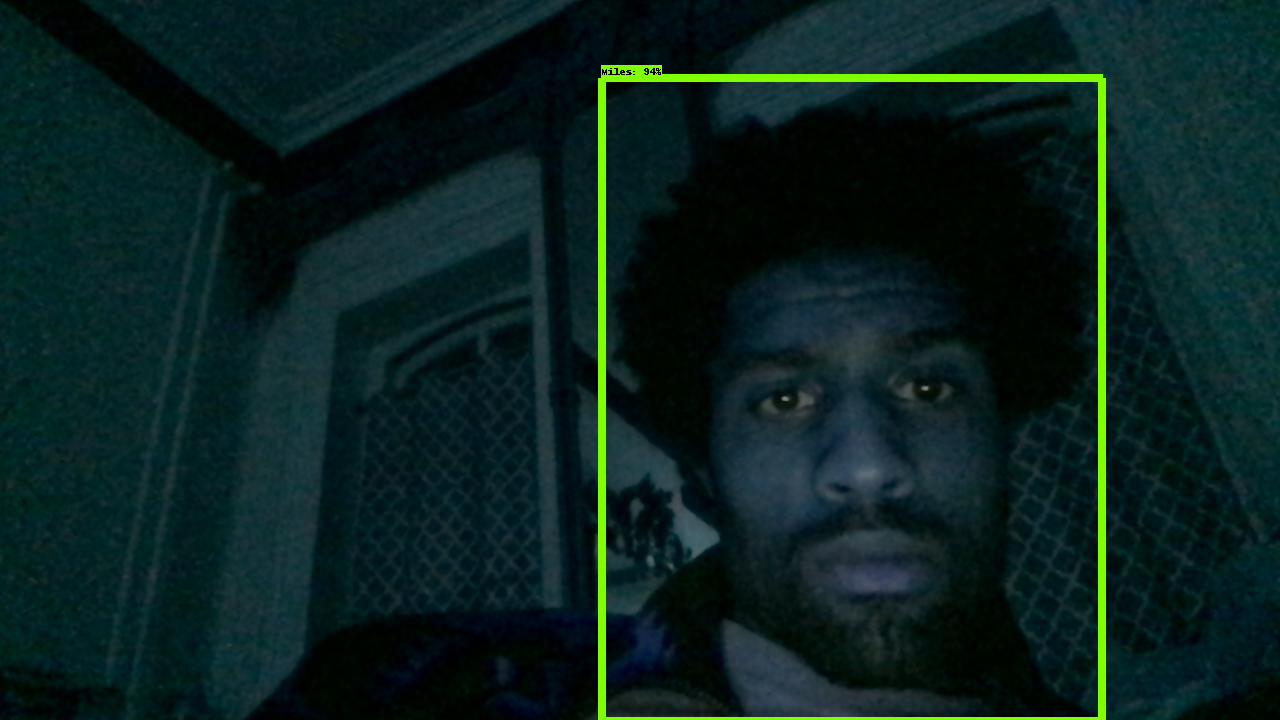

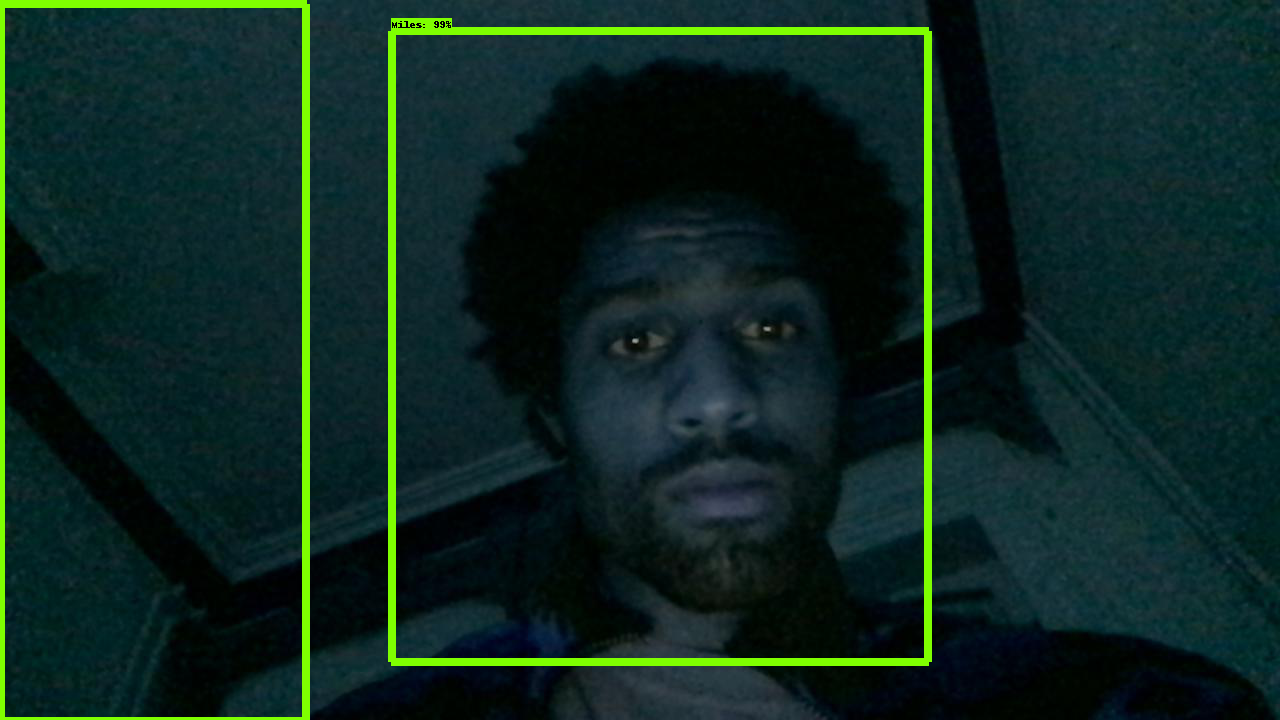

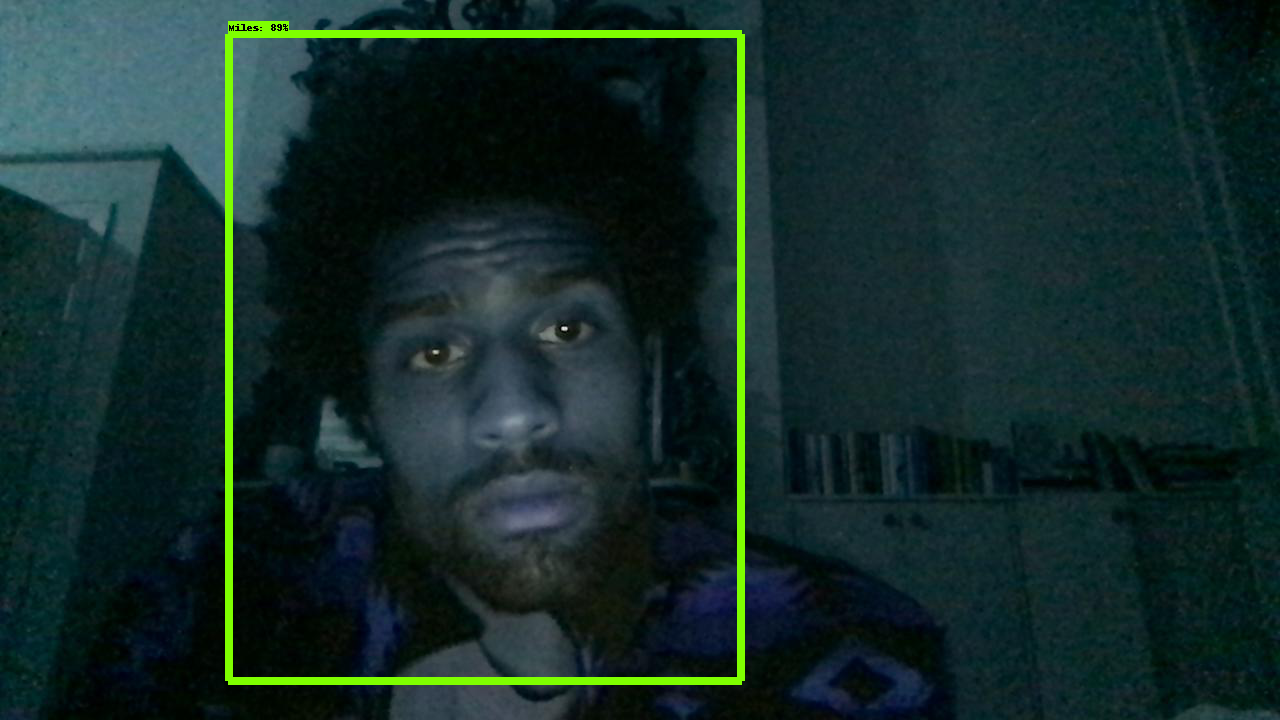

In [ ]:
# images = ['canguru-1.jpeg', 'canguru-2.jpeg', 'canguru-3.jpeg']
images = ["Miles_0.jpeg", "Miles_1.jpeg", "Miles_10.jpeg"]

for image_name in images:
  
  image_np = load_image_into_numpy_array('dataset/images/' + image_name)
  output_dict = run_inference_for_single_image(model, image_np)
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)
  display(Image.fromarray(image_np))

---

### References

[0] Tanner, G. (2020, July 27). Tensorflow Object Detection with Tensorflow 2: Creating a custom model. Retrieved December 28, 2020, from https://gilberttanner.com/blog/tensorflow-object-detection-with-tensorflow-2-creating-a-custom-model

---

[1] Rafiq, H. (2020, December 13). Image Object Detection - TensorFlow 2 Object Detection API. Retrieved December 28, 2020, from https://medium.com/swlh/image-object-detection-tensorflow-2-object-detection-api-af7244d4c34e

---

[2] TensorFlow 2 Detection Model Zoo. (2020, September 09). Tensorflow/models. Retrieved December 28, 2020, from https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md

---

[3] Tensorflow 2 Models Configs. (2020, August 11). Tensorflow/models. Retrieved December 28, 2020, from https://github.com/tensorflow/models/tree/master/research/object_detection/configs/tf2

---
[4] Solawetz, J. (2020, December 09). How to Train YOLOv4 on a Custom Dataset. Retrieved December 28, 2020, from https://blog.roboflow.com/training-yolov4-on-a-custom-dataset/

---

[5] Google Colaboratory. (n.d.). Retrieved January 13, 2021, from https://colab.research.google.com/github/cloud-annotations/google-colab-training/blob/master/object_detection.ipynb#:~:text=The%20TensorFlow%20Object%20Detection%20API%20relies%20on%20what%20are%20called,like%20Python%2C%20Java%20or%20C.
